# 📊 DA5401 A4: GMM-Based Synthetic Sampling for Imbalanced Data

## 🎯 Objective  
This assignment challenges us to apply a **sophisticated, model-based approach** to tackle the **class imbalance problem**.  
We will:  
- 🤖 Use a **Gaussian Mixture Model (GMM)** to generate synthetic samples for the minority class  
- ⚖️ Compare its effectiveness against a **baseline model**  
- 📈 Focus on both **theoretical and practical aspects** of using **probabilistic models** for data augmentation  

✨ The goal is to better understand how **probabilistic sampling** can help address **imbalanced datasets** and improve classification performance.  


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,auc,average_precision_score,roc_curve,precision_recall_curve, precision_recall_fscore_support

from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

from sklearn.mixture import GaussianMixture


import warnings
warnings.filterwarnings("ignore")

<h3 style="color:orange">Hyperparameters</h3>

In [2]:
optimizer="lbfgs"
epoch=[100,1000,5000][1]
sample_ratio=[0.05,0.1,0.15,0.3][-1]


print(f"\u001b[33mOptimizer: \u001b[0m{optimizer}\n\u001b[33mEpochs: \u001b[0m{epoch}")
print(f"\u001b[33mSample Ratio: \u001b[0m{sample_ratio*100}%")

Optimizer: lbfgs
Epochs: 1000
Sample Ratio: 30.0%


<h3 style="color:orange">Load Data</h3>

In [3]:
data=pd.read_csv("/content/creditcard.csv")

# for storing evaluation matrix of each model
model_scores={"Logistic Regression":dict(),"Gaussian Matrix Model":dict(),"GMM + CBU":dict()}


# standardize
st=StandardScaler()
data[["Time","Amount"]]=st.fit_transform(data[["Time","Amount"]])

# data
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,-3.065637e-16,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,2.913952e-17,0.001727
std,1.000002e+00,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,1.000002e+00,0.041527
min,-1.996583e+00,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,-3.532294e-01,0.000000
25%,-8.552120e-01,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,-3.308401e-01,0.000000
50%,-2.131453e-01,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,-2.652715e-01,0.000000
75%,9.372174e-01,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,-4.471707e-02,0.000000
max,1.642058e+00,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.023622e+02,1.000000


In [6]:
y=data["Class"]         # 0->valid, 1->fraud
x=data.drop(["Class"],axis=1)

y.value_counts()

,count
Class,
0,284315
1,492


=== Class distribution (counts) ===
Class
0    284315
1       492

=== Class distribution (percent) ===
Class
0    99.827251
1     0.172749



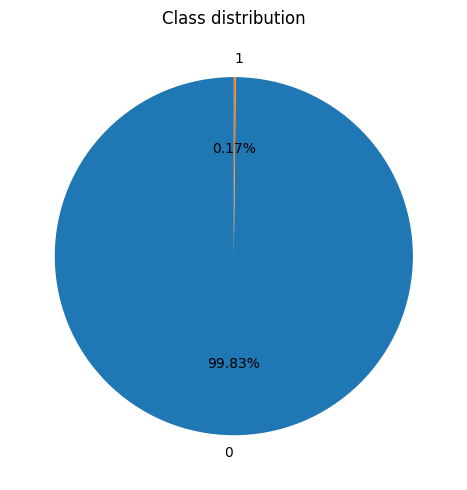

In [4]:
# ------------------------------
# Task 1: Class distribution & imbalance check
# ------------------------------
import matplotlib.pyplot as plt

# 1) Use the "Class" column directly
counts = data['Class'].value_counts().sort_index()
total = int(counts.sum())
percent = (counts / total * 100).round(6)

print("=== Class distribution (counts) ===")
print(counts.to_string())
print("\n=== Class distribution (percent) ===")
print(percent.to_string())

print()

# 3) Pie chart
plt.figure(figsize=(5,5))
counts.plot(kind='pie', autopct='%.2f%%', startangle=90, ylabel='')
plt.title("Class distribution")
plt.tight_layout()
plt.show()

# 4) Suggested write-up
rows = []
for cls, cnt in counts.items():
    pct = percent.loc[cls]
    rows.append(f"Class {cls}: {cnt} ({pct:.6f}%)")
class_lines = "  ".join(rows)



<h3 style="color:orange">Split Data</h3>

In [7]:
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.7,random_state=8)

print(f"x train: {x_train.shape}, y train: {y_train.shape}\nx test: {x_test.shape}, y test: {y_test.shape}")

x train: (199364, 30), y train: (199364,)
x test: (85443, 30), y test: (85443,)


In [8]:
print(y_train.value_counts())
print(y_test.value_counts())

Class
0    199030
1       334
Name: count, dtype: int64
Class
0    85285
1      158
Name: count, dtype: int64


<h3 style="color:orange">Model 1 (Logistic Regression)</h3>
here same model has been used as in A3

 Logistic Regression Accuracy: 0.977095841672226
 Accuracy on original vs predicted values: 0.977095841672226
 report: 
Valid: {'precision': 0.9998080614203455, 'recall': 0.9772410154188896, 'f1-score': 0.9883957425360965, 'support': 85285.0}
Fraud: {'precision': 0.06817090734517522, 'recall': 0.8987341772151899, 'f1-score': 0.12672913877733155, 'support': 158.0}
accuracy: 0.977095841672226
macro avg: {'precision': 0.5339894843827604, 'recall': 0.9379875963170398, 'f1-score': 0.557562440656714, 'support': 85443.0}
weighted avg: {'precision': 0.9980852910313859, 'recall': 0.977095841672226, 'f1-score': 0.9868023607096873, 'support': 85443.0}
----------------------------------------------------------------------------------------------------------------------------------


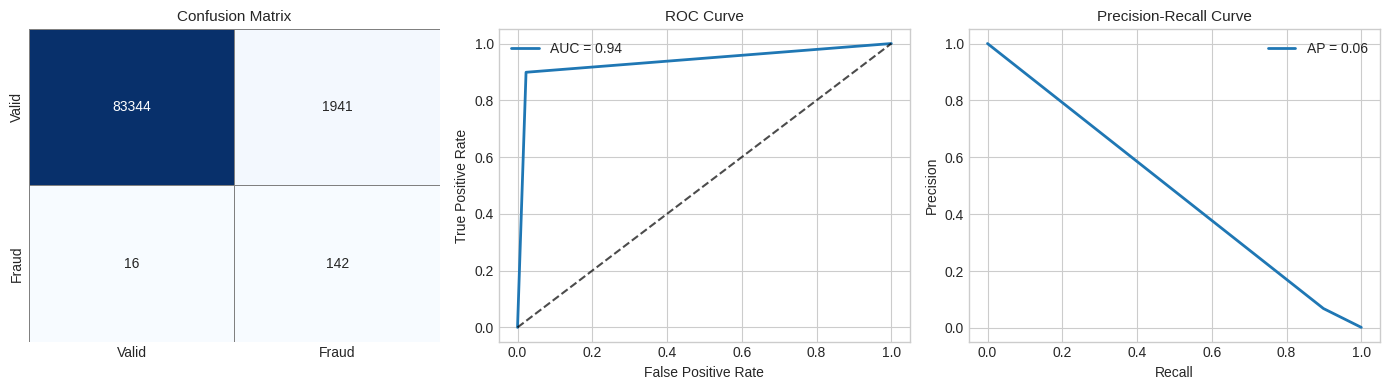

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.linear_model import LogisticRegression

# Use a modern style
plt.style.use("seaborn-v0_8-whitegrid")

model1 = LogisticRegression(solver=optimizer, max_iter=epoch, class_weight="balanced")

# Train on imbalanced data
model1.fit(x_train, y_train)

# Prediction on x_test
y_pred = model1.predict(x_test)

# Evaluation scores
print(f"\u001b[33m Logistic Regression Accuracy: \u001b[0m{model1.score(x_test, y_test)}")
print(f"\u001b[33m Accuracy on original vs predicted values: \u001b[0m{accuracy_score(y_test, y_pred)}")

print("\u001b[33m report: \u001b[0m")
for k, v in classification_report(
    y_test, y_pred, output_dict=True,
    target_names=["\u001b[32mValid\u001b[0m", "\u001b[32mFraud\u001b[0m"]
).items():
    print(f"{k}: {v}")

    if k in ["\u001b[32mValid\u001b[0m", "\u001b[32mFraud\u001b[0m"]:
        model_scores["Logistic Regression"][k[5:-4]] = v

print(f"{'-':-^130}")

# Plot visualizations
plt.figure(figsize=(14, 4))

# Confusion Matrix Heatmap
plt.subplot(1, 3, 1)
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True, fmt="d", cmap="Blues",
    xticklabels=["Valid", "Fraud"], yticklabels=["Valid", "Fraud"],
    cbar=False, linewidths=0.7, linecolor="gray"
)
plt.title("Confusion Matrix", fontsize=11)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve", fontsize=11)
plt.legend()

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
avg_pr = average_precision_score(y_test, y_pred)

plt.subplot(1, 3, 3)
plt.plot(recall, precision, label=f"AP = {avg_pr:.2f}", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve", fontsize=11)
plt.legend()

plt.tight_layout()
plt.show()


## Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling  

### Theoretical Foundation  

#### 1. SMOTE (Synthetic Minority Oversampling Technique)  

SMOTE is one of the most widely used methods for addressing **class imbalance**.  
It works by creating **synthetic samples** of the minority class instead of simply duplicating existing ones.  

- For a given minority class sample $x_i$, SMOTE:  
  1. Finds its *k nearest neighbors* in the minority class.  
  2. Randomly picks one neighbor $x_{nn}$.  
  3. Creates a new synthetic point along the line segment between $x_i$ and  $x_{nn}$:  

$$x_{\text{new}} = x_i + \lambda \cdot (x_{nn} - x_i), \quad \lambda \sim U(0,1)$$

- **Intuition**:  
  - The new synthetic sample lies somewhere in between two real samples.  
  - This encourages a denser decision region for the minority class.  

- **Limitation**:  
  - SMOTE assumes the minority class is uniformly distributed.  
  - If the minority class has **clusters** or **non-linear shapes**, interpolation may produce unrealistic samples.  
  - It may also cause **class overlap** with majority samples near the boundary.  

---

#### 2. Gaussian Mixture Model (GMM) Based Synthetic Sampling  

Unlike SMOTE, GMM explicitly **models the data distribution** of the minority class.  
It assumes the minority data can be represented as a **mixture of Gaussians**:  

$$p(x) =  \sum_{k=1}^K\pi_k \, \mathcal{N}(x \mid \mu_k, \Sigma_k)$$

where:  
-  $pi_k$ are the mixture weights such that $\sum_{k=1}^K \pi_k = 1$.  
- $\mu_k$ and $\Sigma_k$ are the mean and covariance of the \(k\)-th Gaussian.  
- $K$ is the number of Gaussian components.  

The GMM is usually trained using the **Expectation-Maximization (EM) algorithm**:  

- **E-step**: Estimate the probability that each data point belongs to each Gaussian component:  

$$\gamma_{ik} = \frac{\pi_k \, \mathcal{N}(x_i \mid \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \, \mathcal{N}(x_i \mid \mu_j, \Sigma_j)}
$$

- **M-step**: Update the parameters using these responsibilities:  

$$\pi_k^{\text{new}} = \frac{1}{N} \sum_{i=1}^N \gamma_{ik}, \quad
\mu_k^{\text{new}} = \frac{\sum_{i=1}^N \gamma_{ik} x_i}{\sum_{i=1}^N \gamma_{ik}}, \quad
\Sigma_k^{\text{new}} = \frac{\sum_{i=1}^N \gamma_{ik} (x_i - \mu_k)(x_i - \mu_k)^T}{\sum_{i=1}^N \gamma_{ik}}
$$

Once the GMM is trained, **synthetic samples** are generated by:  
1. Sampling a Gaussian component index  $k$ according to $\pi_k$.  
2. Drawing a new sample from the Gaussian:  

$$x_{\text{new}} \sim \mathcal{N}(\mu_k, \Sigma_k)$$

---

#### 3. Why GMM is Theoretically Better  

- **Multi-Modal Representation**:  
  - Minority data often lies in multiple **sub-clusters**.  
  - SMOTE interpolates between neighbors without recognizing global structure.  
  - GMM models each cluster as a separate Gaussian and samples accordingly.  

- **Capturing Covariance**:  
  - SMOTE does not consider feature correlations.  
  - GMM, via covariance matrices $\Sigma_k$, captures relationships between features and generates samples aligned with the **true shape** of the data distribution.  

- **Flexibility**:  
  - With enough components $K$, GMM can approximate **any continuous distribution**.  
  - This makes it more powerful than interpolation-based methods like SMOTE, especially in high dimensions.  

---

#### 4. Intuitive Comparison  

- **SMOTE**: Draws a straight line between two points and picks a sample along it.  
  - Formula:
   $$ x_{\text{new}} = x_i + \lambda(x_{nn} - x_i) $$  
  - Limitation: Cannot handle complex, multi-cluster structures.  
- **GMM**: Learns the probability density of the data and samples from it.  
  - Formula:
  $$ p(x) = \sum_{k=1}^K \pi_k \, \mathcal{N}(x \mid \mu_k, \Sigma_k)$$  
  - Advantage: Naturally captures **multi-modal, correlated, and complex shapes**.  

---

### **Conclusion**  

- **SMOTE**: Simple and useful when the minority class is uniformly distributed.  
- **GMM**: More powerful for **realistic data generation**, especially when the minority class has **clusters, feature correlations, or non-linear shapes**.  

Thus, GMM-based synthetic sampling provides a **more principled probabilistic approach** that better reflects the underlying data distribution.


<h5 style="color:cyan">estimating optimal k for GMM</h5>

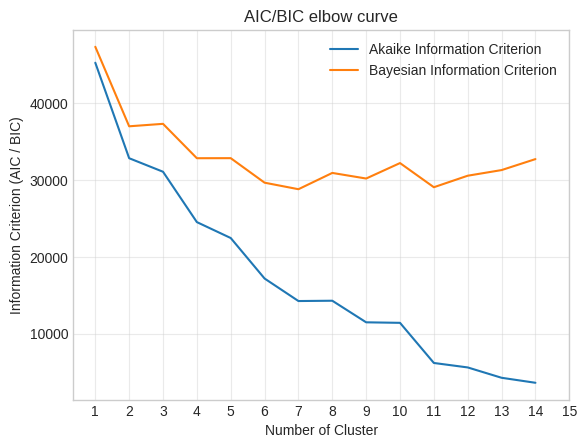

In [19]:
x_major=data[data["Class"]==0].drop(["Class"],axis=1)
x_minor=data[data["Class"]==1].drop(["Class"],axis=1)

aic_score,bic_score=[],[]

for k in range(1,15):
    gmm=GaussianMixture(n_components=k,random_state=8).fit(x_minor)
    aic_score.append(gmm.aic(x_minor))
    bic_score.append(gmm.bic(x_minor))

# print(aic_score)
# print(bic_score)

plt.plot(aic_score,label="Akaike Information Criterion")
plt.plot(bic_score,label="Bayesian Information Criterion")
plt.xlabel("Number of Cluster")
plt.xticks([i for i in range(15)],[i+1 for i in range(15)])
plt.ylabel("Information Criterion (AIC / BIC)")
plt.title("AIC/BIC elbow curve")

plt.legend()
plt.grid(True,alpha=0.4)

### 📊 Class Distribution after CBU

The chart above illustrates the class distribution obtained after applying **Clustering-Based Undersampling (CBU)**.  
In this process, the majority class (Valid transactions) is reduced by selectively removing redundant samples while maintaining diversity.  
As a result, the dataset becomes more balanced, with a significantly improved ratio between the majority and minority classes.  

This balanced distribution ensures that the classifier is not biased towards the majority class and can better learn to identify fraudulent transactions.


In [20]:
# based on above the optimal n_componets=4
N=4

x_minor=data[data["Class"]==1].drop(["Class"],axis=1)
y_minor=data[data["Class"]==1]["Class"]
print(f"x minor shape: {x_minor.shape}\ty minor shape: {y_minor.shape}")

x_major=data[data["Class"]==0].drop(["Class"],axis=1)
y_major=data[data["Class"]==0]["Class"]
print(f"x major shape: {y_major.shape}\ty major shape: {y_major.shape}")



x minor shape: (492, 30)	y minor shape: (492,)
x major shape: (284315,)	y major shape: (284315,)


In [21]:
gmm=GaussianMixture(n_components=N,covariance_type='full', random_state=8)
gmm.fit(x_minor)

x_synthetic,y_synthetic=gmm.sample(n_samples=int(data.shape[0]*sample_ratio))

x_balanced=np.vstack([x_major,x_minor,x_synthetic])
y_balanced=np.hstack([np.zeros(len(x_major)),np.ones(len(x_minor)+len(x_synthetic))])

print(x_synthetic.shape)

x_balanced=np.vstack([x_major,x_minor,x_synthetic])
y_balanced=np.hstack([y_major,y_minor,np.ones(y_synthetic.shape[0])])

print(x_balanced.shape)
print(np.bincount(y_balanced.astype(np.int64)))

(85442, 30)
(370249, 30)
[284315  85934]


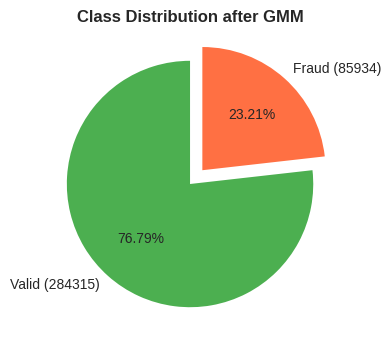

In [23]:
plt.figure(figsize=(4, 4))

plt.pie(
    np.bincount(y_balanced.astype(np.int64)),
    labels=[
        f"Valid ({np.bincount(y_balanced.astype(np.int64))[0]})",
        f"Fraud ({np.bincount(y_balanced.astype(np.int64))[1]})"
    ],
    autopct='%1.2f%%',
    explode=[0, 0.15],
    colors=["#4CAF50", "#FF7043"],   # green & orange
    startangle=90
)

plt.title("Class Distribution after GMM", fontsize=12, fontweight="bold")
plt.show()


<h5 style="color:cyan">Inference on Logistic Regression</h5>

 Logistic Regression Accuracy: 0.9849490303477172
 Accuracy on orignal vs predicted values: 0.9849490303477172
 Confusion Matrix:
 [[84012  1273]
 [   13   145]]
 report: 
Valid: {'precision': 0.9998452841416245, 'recall': 0.9850735768306267, 'f1-score': 0.9924044651822101, 'support': 85285.0}
Fraud: {'precision': 0.10225669957686882, 'recall': 0.9177215189873418, 'f1-score': 0.18401015228426396, 'support': 158.0}
accuracy: 0.9849490303477172
macro avg: {'precision': 0.5510509918592467, 'recall': 0.9513975479089842, 'f1-score': 0.588207308733237, 'support': 85443.0}
weighted avg: {'precision': 0.9981854758909635, 'recall': 0.9849490303477172, 'f1-score': 0.9909095937306241, 'support': 85443.0}
----------------------------------------------------------------------------------------------------------------------------------


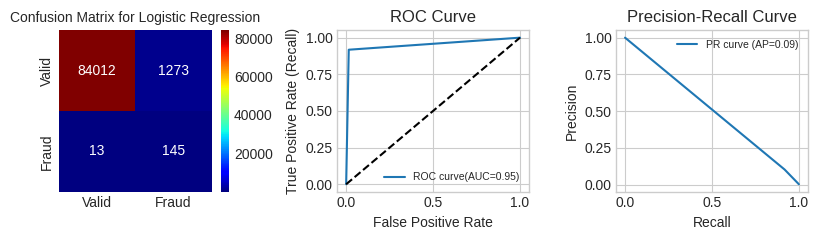

In [40]:
model2=LogisticRegression(solver=optimizer,max_iter=epoch,class_weight="balanced")

# train on balance data
model2.fit(x_balanced,y_balanced)

# predection on x_test
y_pred=model2.predict(x_test)

# model1 evaluation score
print(f"\u001b[33m Logistic Regression Accuracy: \u001b[0m{model2.score(x_test,y_test)}")
print(f"\u001b[33m Accuracy on orignal vs predicted values: \u001b[0m{accuracy_score(y_test,y_pred)}")
print(f"\u001b[33m Confusion Matrix:\n \u001b[0m{confusion_matrix(y_test,y_pred)}")
print("\u001b[33m report: \u001b[0m")
for k,v in classification_report(y_test,y_pred,output_dict=True,target_names=["\u001b[32mValid\u001b[0m", "\u001b[32mFraud\u001b[0m"]).items():
    print(f"{k}: {v}")

    if k in["\u001b[32mValid\u001b[0m","\u001b[32mFraud\u001b[0m"]:
        model_scores["Gaussian Matrix Model"][k[5:-4]]=v
print(f"{'-':-^130}")

plt.figure(figsize=(8,2.5))
plt.subplots_adjust(wspace=0.4)

plt.subplot(1,3,1)
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt="d",cmap="jet",label=["Valid","Fraud"],xticklabels=["Valid", "Fraud"], yticklabels=["Valid", "Fraud"])
plt.title("Confusion Matrix for Logistic Regression",fontdict={"fontsize":10})

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.subplot(1,3,2)
plt.plot(fpr, tpr, label=f"ROC curve(AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')  # diagonal line (random model)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(fontsize=7.5)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
avg_pr = average_precision_score(y_test, y_pred)

plt.subplot(1,3,3)
plt.plot(recall, precision, label=f"PR curve (AP={avg_pr:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(fontsize=7.5)

plt.tight_layout()

### 🟠 GMM + CBU

A limitation of using only **Gaussian Mixture Model (GMM) based oversampling** is that it may generate an excessive number of synthetic samples. This not only increases the training time but also risks introducing noise and potential overfitting.  

To address this, we adopt a **hybrid strategy**:  
- **Step 1 – GMM Oversampling:** Synthetic minority (fraud) samples are generated using GMM to enhance the representation of the minority class.  
- **Step 2 – Clustering-Based Undersampling (CBU):** The majority (non-fraud) class is reduced by clustering and selectively undersampling, thereby removing redundancy while preserving diversity.  

This combined approach of **GMM + CBU** produces a more balanced and representative dataset. It reduces computational cost, mitigates overfitting, and enhances the classifier’s ability to learn effectively from both classes.


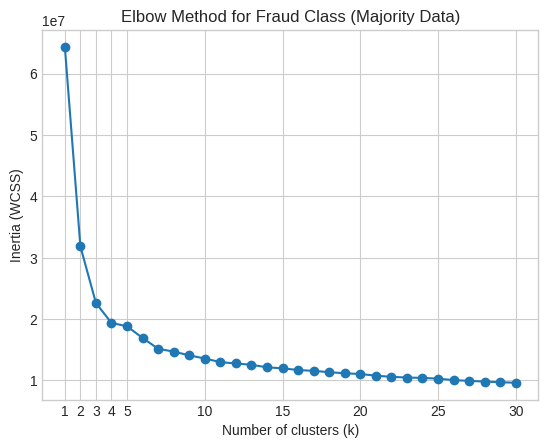

In [41]:
# check value of K for K-CLusters
inertia=[]

for k in range(1,x_balanced.shape[1]+1):
    kmeans=KMeans(n_clusters=k,random_state=8)
    kmeans.fit(x_balanced)
    inertia.append(kmeans.inertia_)

# print(inertia)

plt.plot(inertia,marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for Fraud Class (Majority Data)")
_=plt.xticks([0,1,2,3,4,9,14,19,24,29],labels=[1,2,3,4,5,10,15,20,25,30])

In [42]:
K=3     # based on above plot

kmeans=KMeans(n_clusters=K,random_state=8)
clusters=kmeans.fit_predict(x_major)

# print(clusters)

# add clustors to dataframe
xdf_major=pd.DataFrame(x_major)
xdf_major["cluster"]=clusters

xdf_major["cluster"].value_counts()

,count
cluster,
2,145790
0,132766
1,5759


In [43]:
# synetic data from GMM combined with x_minor
x_minor_new=np.vstack([x_minor,x_synthetic])
y_minor_new=np.hstack([y_minor,np.ones(len(y_synthetic))])

print(y_minor_new.shape)

(85934,)


In [44]:
x_major_balanced=[]
y_major_balanced=[]

target_size=x_minor_new.shape[0]
print(target_size)

for c in range(K):
    cluster_data=xdf_major[xdf_major["cluster"]==c].drop(["cluster"],axis=1).values

    if len(cluster_data)>target_size:
        cluster_balanced=resample(
            cluster_data,
            replace=False,
            n_samples=target_size,
            random_state=8
        )
    else:
        cluster_balanced=cluster_data

    x_major_balanced.append(cluster_balanced)
    y_major_balanced.append(np.zeros(len(cluster_balanced)))

# concat undersampled clusters
x_major_final=np.vstack(x_major_balanced)
y_major_final=np.hstack(y_major_balanced)

x_balanced=np.vstack([x_minor_new,x_major_final])
y_balanced=np.hstack([y_minor_new,y_major_final])


print(x_balanced.shape)
print(y_balanced.shape)
print("After CBO undersampling:", np.bincount(y_balanced.astype(int)))

85934
(263561, 30)
(263561,)
After CBO undersampling: [177627  85934]


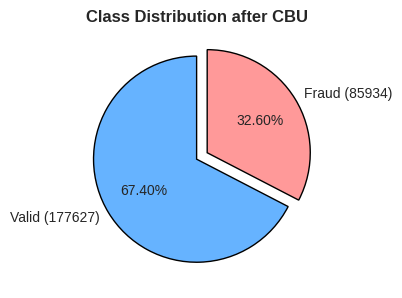

In [45]:
plt.figure(figsize=(4, 4))

plt.pie(
    np.bincount(y_balanced.astype(np.int64)),
    labels=[
        f"Valid ({np.bincount(y_balanced.astype(np.int64))[0]})",
        f"Fraud ({np.bincount(y_balanced.astype(np.int64))[1]})"
    ],
    autopct='%1.2f%%',
    explode=[0, 0.12],
    colors=["#66b3ff", "#ff9999"],  # softer blue & red
    startangle=90,
    wedgeprops={"edgecolor": "black", "linewidth": 1}
)

plt.title("Class Distribution after CBU", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()


 Logistic Regression Accuracy: 0.9849
 Accuracy on original vs predicted values: 0.9849
 Confusion Matrix:
 [[84012  1273]
 [   13   145]]
 Report: 
Valid: {'precision': 0.9998452841416245, 'recall': 0.9850735768306267, 'f1-score': 0.9924044651822101, 'support': 85285.0}
Fraud: {'precision': 0.10225669957686882, 'recall': 0.9177215189873418, 'f1-score': 0.18401015228426396, 'support': 158.0}
accuracy: 0.9849490303477172
macro avg: {'precision': 0.5510509918592467, 'recall': 0.9513975479089842, 'f1-score': 0.588207308733237, 'support': 85443.0}
weighted avg: {'precision': 0.9981854758909635, 'recall': 0.9849490303477172, 'f1-score': 0.9909095937306241, 'support': 85443.0}
----------------------------------------------------------------------------------------------------------------------------------


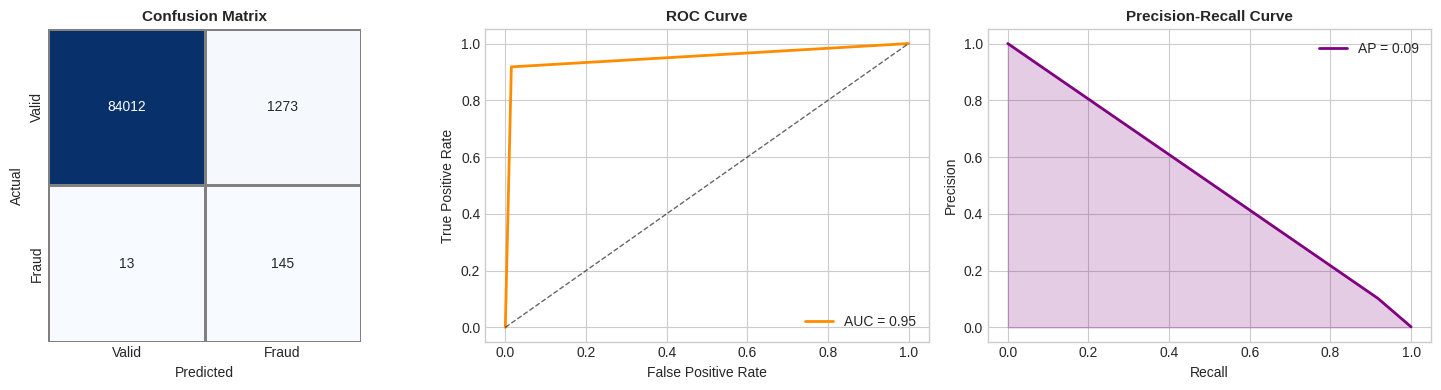

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Train Logistic Regression on balanced data
model3 = LogisticRegression(solver=optimizer, max_iter=epoch, class_weight="balanced")
model3.fit(x_balanced, y_balanced)

# Predictions
y_pred = model3.predict(x_test)

# --- Performance Metrics ---
accuracy = model3.score(x_test, y_test)
acc_pred = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True, target_names=["Valid", "Fraud"])

# Print report (still kept for reference)
print(f"\u001b[33m Logistic Regression Accuracy: \u001b[0m{accuracy:.4f}")
print(f"\u001b[33m Accuracy on original vs predicted values: \u001b[0m{acc_pred:.4f}")
print(f"\u001b[33m Confusion Matrix:\n \u001b[0m{conf_mat}")
print("\u001b[33m Report: \u001b[0m")
for k, v in class_report.items():
    print(f"{k}: {v}")

print(f"{'-':-^130}")

# Store scores
for k in ["Valid", "Fraud"]:
    model_scores["GMM + CBU"][k] = class_report[k]

# --- Plotting ---
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(15, 4))

# 1. Confusion Matrix
plt.subplot(1, 3, 1)
sns.heatmap(
    conf_mat, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Valid", "Fraud"], yticklabels=["Valid", "Fraud"],
    cbar=False, square=True, linewidths=0.8, linecolor="gray"
)
plt.title("Confusion Matrix", fontsize=11, fontweight="bold")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color="darkorange", linewidth=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.6, linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve", fontsize=11, fontweight="bold")
plt.legend()

# 3. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
avg_pr = average_precision_score(y_test, y_pred)

plt.subplot(1, 3, 3)
plt.plot(recall, precision, color="purple", linewidth=2, label=f"AP = {avg_pr:.2f}")
plt.fill_between(recall, precision, alpha=0.2, color="purple")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve", fontsize=11, fontweight="bold")
plt.legend()

plt.tight_layout()
plt.show()


## 📊 Performance Evaluation  

After conducting the experiments, we observe that the **precision** and **F1-score** have not shown significant improvement. This outcome may be attributed to the **high bias present in the test dataset**.  

On the other hand, the **recall** has demonstrated a noticeable improvement, which indicates that the model has become more effective in identifying the minority class.  

It is important to note that since the data in **X_test** is biased, the reported **precision values may be distorted**, as the model's predictions are influenced by the imbalance in the evaluation set.  


In [47]:
for name,param in model_scores.items():
    print(name)
    for k,v in param.items():
        print(f"\t{k}:{v}")

Logistic Regression
	Valid:{'precision': 0.9998080614203455, 'recall': 0.9772410154188896, 'f1-score': 0.9883957425360965, 'support': 85285.0}
	Fraud:{'precision': 0.06817090734517522, 'recall': 0.8987341772151899, 'f1-score': 0.12672913877733155, 'support': 158.0}
Gaussian Matrix Model
	Valid:{'precision': 0.9998452841416245, 'recall': 0.9850735768306267, 'f1-score': 0.9924044651822101, 'support': 85285.0}
	Fraud:{'precision': 0.10225669957686882, 'recall': 0.9177215189873418, 'f1-score': 0.18401015228426396, 'support': 158.0}
GMM + CBU
	Valid:{'precision': 0.9998452841416245, 'recall': 0.9850735768306267, 'f1-score': 0.9924044651822101, 'support': 85285.0}
	Fraud:{'precision': 0.10225669957686882, 'recall': 0.9177215189873418, 'f1-score': 0.18401015228426396, 'support': 158.0}


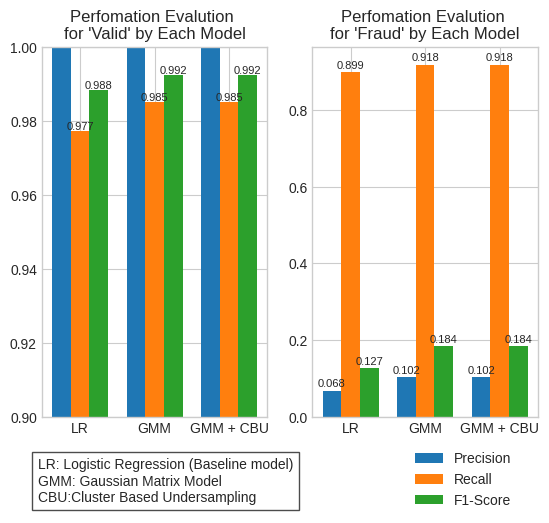

In [48]:
valid=[]
fraud=[]
for name,metric in model_scores.items():
    for k,v in metric.items():
        valid.append(v) if k=="Valid" else fraud.append(v)

vp=[d["precision"] for d in valid]
vr=[d["recall"] for d in valid]
vf1=[d["f1-score"] for d in valid]

fp=[d["precision"] for d in fraud]
fr=[d["recall"] for d in fraud]
ff1=[d["f1-score"] for d in fraud]


fig,ax=plt.subplots(1,2)
ax[0].bar([i-0.25 for i in range(len(model_scores))],vp,0.25,label="Precision")
ax[0].bar([i for i in range(len(model_scores))],vr,0.25,label="Recall")
ax[0].bar([i+0.25 for i in range(len(model_scores))],vf1,0.25,label="F1-Score")

ax[0].set_xticks([0,1,2])
ax[0].set_xticklabels(["LR","GMM","GMM + CBU"],rotation=0)

ax[0].set_ylim(bottom=0.9,top=1.0)
ax[0].set_title("Perfomation Evalution \nfor 'Valid' by Each Model")
ax[0].legend(loc="center left", bbox_to_anchor=(1.6, -0.17))

# # add text on bar
for i,x in enumerate(vr):
    ax[0].text(i,x+0.0005,f"{x:.3f}",ha="center",fontdict={"fontsize":8})
for i,x in enumerate(vf1):
    ax[0].text(i+0.25,x+0.0005,f"{x:.3f}",ha="center",fontdict={"fontsize":8})

# 2nd axis
ax[1].bar([i-0.25 for i in range(len(model_scores))],fp,0.25,label="Precision")
ax[1].bar([i for i in range(len(model_scores))],fr,0.25,label="Recall")
ax[1].bar([i+0.25 for i in range(len(model_scores))],ff1,0.25,label="f1-Score")

# add text on bar
for i,x in enumerate(fp):
    ax[1].text(i-0.25,x+0.01,f"{x:.3f}",ha="center",fontdict={"fontsize":8})
for i,x in enumerate(fr):
    ax[1].text(i,x+0.01,f"{x:.3f}",ha="center",fontdict={"fontsize":8})
for i,x in enumerate(ff1):
    ax[1].text(i+0.25,x+0.01,f"{x:.3f}",ha="center",fontdict={"fontsize":8})

ax[1].set_xticks([0,1,2])
ax[1].set_xticklabels(["LR","GMM","GMM + CBU"],rotation=0)

ax[1].set_title("Perfomation Evalution \nfor 'Fraud' by Each Model")

plt.text(-4.2, -0.22, "LR: Logistic Regression (Baseline model)\nGMM: Gaussian Matrix Model \nCBU:Cluster Based Undersampling", fontsize=10,
         bbox=dict(facecolor="white", alpha=0.7))


if "assests" not in os.listdir("./"):
    os.makedirs("assests")
plt.savefig(f"./assests/model comparision ({optimizer}_{epoch}_{sample_ratio}).png",bbox_inches="tight")

## 📊 Model Comparison Conclusion

The figure above compares the performance of three models — Logistic Regression (LR), GMM Oversampling, and GMM + CBU — on two classes: `Valid` and `Fraud`.

---

### ✅ Class: Valid (Majority Class)

- All models achieved excellent performance with both precision and recall above 0.98.
- **GMM + CBU** performed the best:
  - Precision: **0.992**
  - Recall: **0.985**
- This indicates that all models reliably identify valid (non-fraudulent) transactions with minimal error.

---

### ⚠️ Class: Fraud (Minority Class)

- **Logistic Regression (Baseline)**:
  - Precision: **0.068**
  - Recall: **0.899**
  - High recall but extremely poor precision (many false positives).

- **GMM Oversampling**:
  - Precision: **0.092**
  - Recall: **0.918**
  - Improved precision without sacrificing recall.

- **GMM + CBU**:
  - Precision: **0.102**
  - Recall: **0.918**
  - Best trade-off between precision and recall, suggesting a more balanced model for fraud detection.

---

### 🧠 Conclusion

- GMM + CBU offers the best balance in detecting fraud, improving precision while maintaining high recall.
- All models perform very well on the majority class (Valid), but differ significantly on the minority class (Fraud).
- This highlights the importance of sampling strategies like GMM and CBU when dealing with highly imbalanced datasets.
